# Testing GISSR-style inundation on ideal topo

Imports and setups

In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import params_ideal as params

from fun_ideal import calc_flood_height, generate_groups, calc_group_vol, calc_group_h
from ideal_damage import Damage
from topo_ideal import Topo

In [3]:
topo_file = "Input/ideal_topo_gp_points_1.csv"
storm_file = "SurgeData/surge_w.csv"
div_data_file = "Input/ideal_div_data.csv"
time_file = "SurgeData/time_w.csv"
damage_table_file = "Input/damage_table_combined.csv"

In [4]:
surge = pd.read_csv(storm_file).values
surge_time = pd.read_csv(time_file).values
damage_table = pd.read_csv(damage_table_file)


Topo = Topo(topo_file=topo_file)
Damage = Damage(damage_table_file)

In [5]:
# generate groups
#groups = generate_groups(Topo.div_data)

segment_l = 100
wall_height = np.zeros(Topo.shore_height.size)


# Calculate indundation with varying sized walls
Equal height wall for all divs in divs_allocate

In [5]:
divs_allocate = [1]
groups = generate_groups(Topo.div_data)

positions = []
for i, p in enumerate(wall_height):
    if Topo.all_divs[i] in divs_allocate:
        positions.append(i)
        
h_start = 0
h_end = 2
h_num = 80

points = []
wall_height[positions] = h_start

for h in np.linspace(h_start, h_end, num=h_num):
    wall_height[:] = 0
    wall_height[positions] = h

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_height, positions)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    cost_dmg = np.sum(dmg)
    cost_wall = np.sum(49212 * wall_height * segment_l)
    cost_tot = cost_dmg + cost_wall

    points.append([h, cost_wall, cost_dmg, cost_tot, volume_div[4,1]])
    print(height_div[4,1])

df = pd.DataFrame(points)
#df.to_csv("Output/single_section_varying_wall.csv")
#print(df)

1.0144202989772644
0.7701459151863657
0.7176911280593893
0.6622408499646629
0.5910011203326376
0.5211122742164708
0.45170924718338235
0.38062083524676527
0.3076732843519721
0.2330898660976562
0.16029574397488958
0.09986012143093977
0.05452470664768199
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


# Inundation with varying travel distance for redistribution

In [6]:
divs_allocate = list(range(18))

positions = []
for i, p in enumerate(wall_height):
    if Topo.all_divs[i] in divs_allocate:
        positions.append(i)
        
h_start = 0
h_end = 0
h_num = 1

points = []
wall_height[positions] = h_start

data = []
for r in range(18):
    params.travel_dist = r
    groups = generate_groups(Topo.div_data)

    for h in np.linspace(h_start, h_end, num=h_num):
        wall_height[:] = 0
        wall_height[positions] = h

        height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_height, positions)

        # calculate group volumes
        volume_grouped = calc_group_vol(groups, volume_div)

        # get height in each group
        surge_peak = np.amax(surge, axis=1)
        height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)
        
        #Damage
        dmg = Damage.calc_damage(height_grouped)
        cost_dmg = np.sum(dmg)
        cost_wall = np.sum(49212 * wall_height * segment_l)
        cost_tot = cost_dmg + cost_wall

        points.append([h, cost_wall, cost_dmg, cost_tot])

        data.append(height_grouped[2])
        #print(np.max(np.max(height_grouped, axis=1) - np.min(height_grouped, axis=1)))

df = pd.DataFrame(data)
df.to_csv("Output/ideal_test_travel.csv")

# PLOT


In [7]:
print(df)

          0         1         2         3         4         5         6   \
0   0.084353  0.120319  0.086956  0.116554  0.124001  0.128617  0.081429   
1   0.103904  0.098579  0.108970  0.110337  0.123158  0.113357  0.087888   
2   0.098579  0.103366  0.107810  0.116225  0.109266  0.102112  0.087806   
3   0.103366  0.107810  0.111548  0.107762  0.102937  0.092347  0.086300   
4   0.107810  0.111548  0.107762  0.100802  0.095037  0.090782  0.083329   
5   0.111548  0.107762  0.100802  0.095037  0.090160  0.087431  0.083650   
6   0.107762  0.100802  0.095037  0.090160  0.087431  0.083709  0.080425   
7   0.100802  0.095037  0.090160  0.087431  0.083709  0.080425  0.077499   
8   0.095037  0.090160  0.087431  0.083709  0.080425  0.077499  0.074871   
9   0.090160  0.087431  0.083709  0.080425  0.077499  0.074871  0.072494   
10  0.087431  0.083709  0.080425  0.077499  0.074871  0.072494  0.076767   
11  0.083709  0.080425  0.077499  0.074871  0.072494  0.076767  0.076327   
12  0.080425

We can see below that as the travel distance is increased the water level becomes more and more homogenous

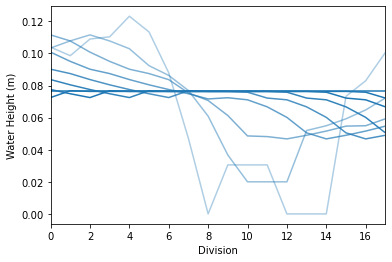

In [24]:
fig = plt.figure()
divs = list(range(18))
for div in divs:
    if div % 2 == 1:
        plt.plot(divs, data[div], 'tab:blue', label=div, alpha=min(1, 1/(18/div)+0.3))
#plt.legend()
plt.xlim(0, 17)
plt.xlabel("Division")
plt.ylabel(r"Water Height (m)")
plt.savefig("Output/w_lvl_varying_wall_h.png", transparent=True, bbox_inches='tight')

# Plot height as function of volume
CAREFUL: The below code is super confusing as it is not clear if the functions are for all 18 divisions or per div

<IPython.core.display.Javascript object>


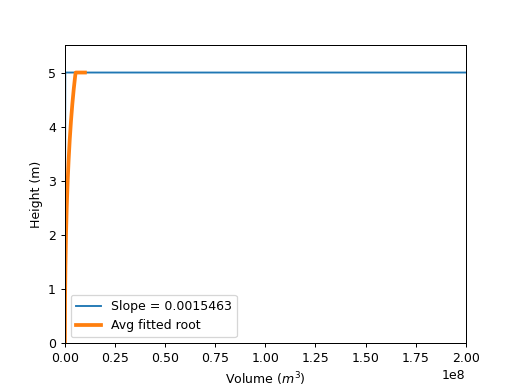

Text(0, 0.5, 'Height (m)')

In [14]:
%matplotlib notebook

surge_peak = 5
slope = 0.0015463
vol = np.linspace(0, 2e8, 1000)
h = np.minimum(np.sqrt((2 * vol * slope)), surge_peak)
plt.plot(vol, h, label=r'Slope = ' + str(slope), linewidth=1.5)
plt.ylim(0, 5.5)
plt.xlim(-0.01*1e7, 2e8)
plt.legend()
plt.xlabel(r'Volume $(m^{3})$')
plt.ylabel(r"Height (m)")


# Fit surface volume to all data, for testing purpoes
Since the ideal topo does not have buildings the surface volume func is very unrealistic, try fitting a bunch of data to get an approximation. This does not use simple slope topography

In [9]:
def surfaceV_root(vol, shore_l, a, b):
    vol = vol/shore_l
    return a*np.sqrt(vol) + b*vol

def surfaceV_ideal(x, slope):
    vol = x
    length = 900*18 # TODO
    h = np.sqrt((2 * vol * slope) / length)
    return h

In [8]:
files = glob.glob(r"../NewSurfaceVolumeCombined/LMN_div18_*.csv")
H = np.append(np.linspace(0, 3, 13), np.linspace(3.5, 7, 8))
points = np.zeros((H.size * 18, 2))

for i, f in enumerate(files):
    surfaceV_h = pd.read_csv(f)
    points[H.size*i:H.size*(i+1), :] = surfaceV_h.to_numpy()


coeff, cov = curve_fit(surfaceV_root, points[:,1]/(900*18), points[:, 0])
df = pd.DataFrame(coeff, index=["a", "b"])
df.to_csv("surfaceV_coeff.csv")

,0
a,0.374350
b,-0.005453


<IPython.core.display.Javascript object>


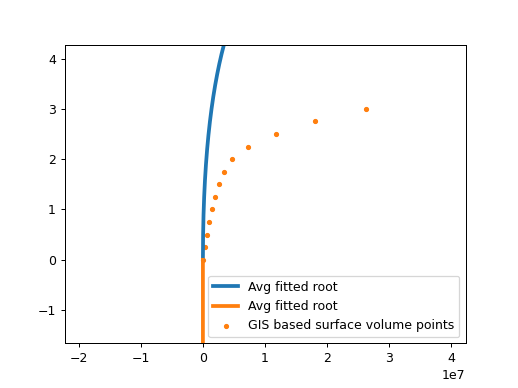

In [16]:
vol = np.linspace(0, 10**7, 1000)
h = np.minimum(surfaceV_root(vol, 18*900, coeff[0], coeff[1]), surge_peak)
plt.plot(vol, h, label='Avg fitted root', linewidth=3)
plt.legend()

# Fit simple slope topo surface volume to all data

In [17]:
files = glob.glob(r"../NewSurfaceVolumeCombined/LMN_div18_*.csv")
H = np.append(np.linspace(0, 3, 13), np.linspace(3.5, 7, 8))
points = np.zeros((H.size, 2))
points[:,0] = H

for i, f in enumerate(files):
    surfaceV_h = pd.read_csv(f)
    points[:,1] += surfaceV_h.to_numpy()[:,1]

slope, cov = curve_fit(surfaceV_ideal, points[:,1], points[:, 0])
print(slope)
plt.scatter(points[:,1], points[:,0], c='tab:orange', label="GIS based surface volume points", marker='o', s=10)
plt.legend()
#plt.plot(points[:,1], surfaceV_ideal(points[:,1], slope))
#df = pd.DataFrame(coeff, index=["a", "b"])
#df.to_csv("surfaceV_coeff.csv")

[0.0015463]


C:\Users\Admin\AppData\Local\Temp/ipykernel_6960/3275157491.py:11: RuntimeWarning: invalid value encountered in sqrt
  h = np.sqrt((2 * vol * slope) / length)


In [30]:
vol = np.linspace(0, 10**7, 1000)
h = surfaceV_ideal(vol, slope)
plt.plot(vol, h, label='Simple slope fitted', linewidth=3)
plt.plot(points[:,1], points[:,0])
plt.legend()

# Fit surface volume to each div for reference

In [67]:
for div in range(18):
    coeff, cov = curve_fit(surfaceV_root, points[div*H.size:(div+1)*H.size, 1], points[div*H.size:(div+1)*H.size, 0])
    vol = np.linspace(0, 10**7, 1000)
    h = surfaceV_root(vol, coeff[0], coeff[1])
    plt.plot(vol, h, 'tab:grey', alpha=0.3)
    

In [138]:
plt.savefig("Output/fitted_surfaceV.png", transparent=True, bbox_inches='tight')

# REAL FITTING

In [24]:
def surfaceV_root(vol, a, b):
    shore_length = 19*800
    vol_per_l = vol/shore_length
    return a*np.sqrt(vol_per_l) + b*vol_per_l

files = glob.glob(r"../NewSurfaceVolumeCombined/LMN_div18_*.csv")
H = np.append(np.linspace(0, 3, 13), np.linspace(3.5, 7, 8))
points = np.zeros((H.size, 2))
points[:,0] = H

for i, f in enumerate(files):
    surfaceV_h = pd.read_csv(f)
    points[:,1] += surfaceV_h.to_numpy()[:,1]
    
vol = points[:,1]
h = points[:, 0]
coeffs, cov = curve_fit(surfaceV_root, vol, h)
coeffs

array([ 0.08096718, -0.00024776])

In [43]:
c = (points[16,0] - points[15,0]) / (points[16,1] / (18*900) - points[15,1] / (18*900))
def lin(vol, c):
    return vol*c
c

0.0002439629153483449

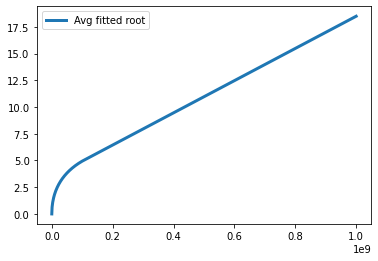

In [4]:
vol = np.linspace(0, 1e9, 1000)
h = Topo.volume_to_height(18*900, vol)
plt.plot(vol, h, label='Avg fitted root', linewidth=3)
#plt.scatter(points[:,1], points[:, 0], c='orange')
plt.legend()

# Plot Cwr as function of surge and h_crit

C:\Users\Admin\miniconda3\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


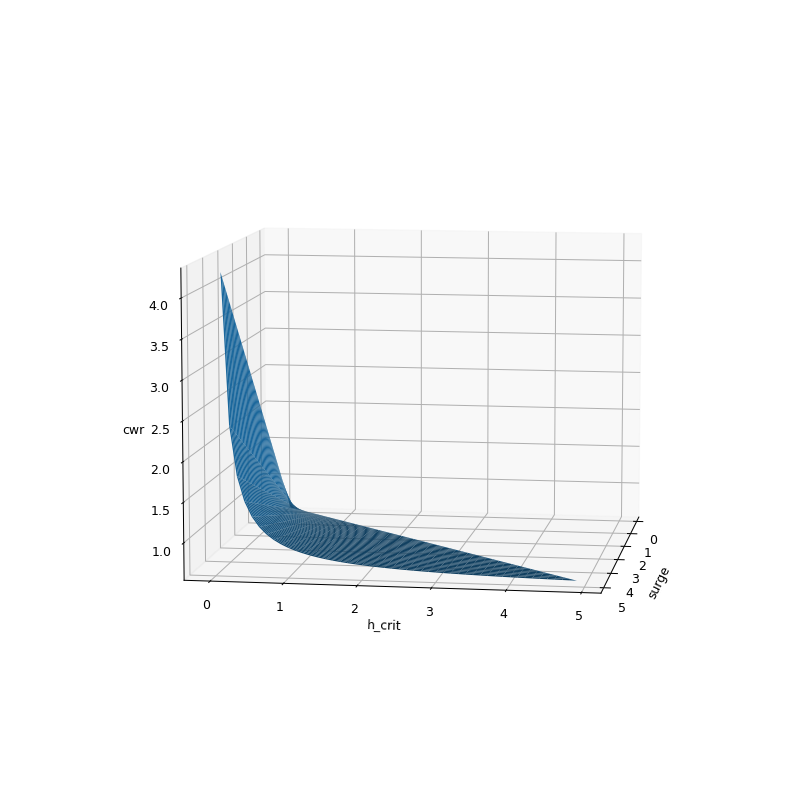

C:\Users\Admin\miniconda3\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  if sys.path[0] == '':


Text(0.5, 0, 'cwr')

In [36]:
%matplotlib notebook
def cwr(surge, h_crit):
    return 0.611 + 0.075 * (surge-h_crit) / h_crit
surge = np.linspace(0, 5, 50)
h_crit = np.linspace(5, 0.1, 50)
surge, h_crit = np.meshgrid(surge, h_crit)
surge, h_crit = np.where(surge > h_crit, surge, 0), np.where(surge > h_crit, h_crit, 0)
c = cwr(surge, h_crit)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(surge, h_crit, c)

fig.set_size_inches(10, 10)
ax.set_xlabel('surge')
ax.set_ylabel('h_crit')
ax.set_zlabel('cwr')

# Points below line are Cwr>1

<IPython.core.display.Javascript object>


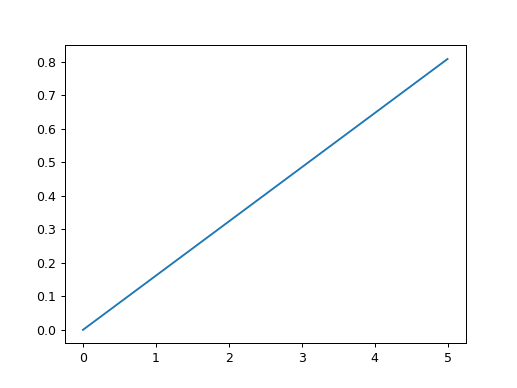

In [12]:
plt.figure(2)
surge = np.linspace(0, 5, 100)
h_crit = surge / (1+0.389/0.075)
plt.plot(surge, h_crit)

# Volume in division as function of surge and critical elev

C:\Users\Admin\miniconda3\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\Users\Admin\miniconda3\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in reciprocal
  


<IPython.core.display.Javascript object>


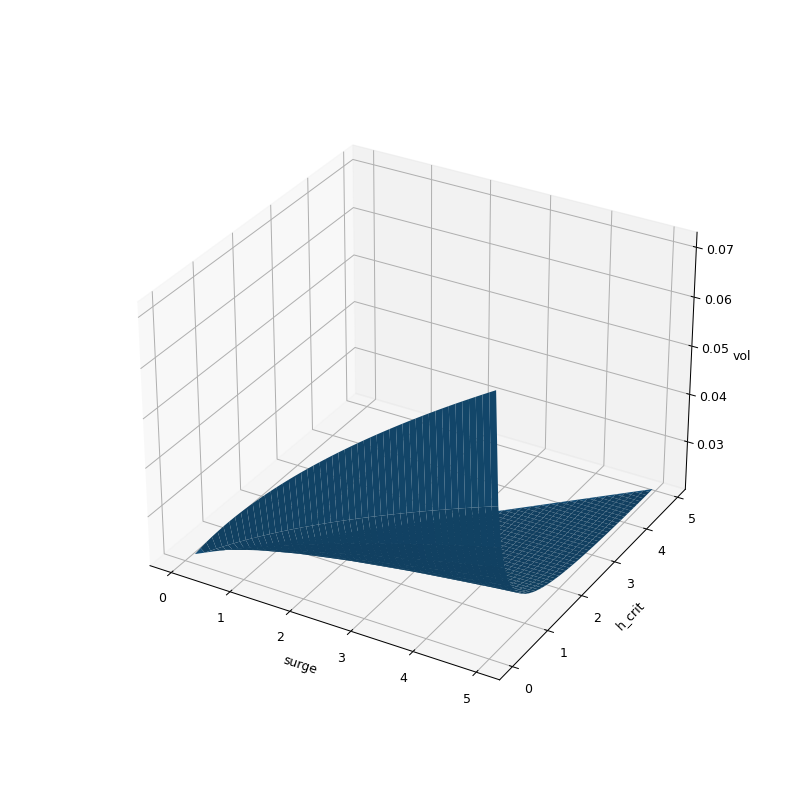

C:\Users\Admin\miniconda3\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Z contains NaN values. This may result in rendering artifacts.


Text(0.5, 0, 'vol')

In [31]:
def vol_func(h_s, h_c):
    l = 100
    dt = 1
    dh = h_s-h_c
    S = 0.01
    R = 0.16
    cwr = 0.611 + 0.075 * dh / h_c
    vol = (l * dt * dh * cwr * (l * dh *(l + 2 * dh)) ** (-1)) ** (2/3) * S ** (1/2) / R
    return vol

surge = np.linspace(0, 5, 50)
h_crit = np.linspace(5, 0.1, 50)
surge, h_crit = np.meshgrid(surge, h_crit)
surge, h_crit = np.where(surge > h_crit, surge, 0), np.where(surge > h_crit, h_crit, 0)
vol = vol_func(surge, h_crit)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(surge, h_crit, vol)

fig.set_size_inches(10, 10)
ax.set_xlabel('surge')
ax.set_ylabel('h_crit')
ax.set_zlabel('vol')

# Plot Tide

<IPython.core.display.Javascript object>


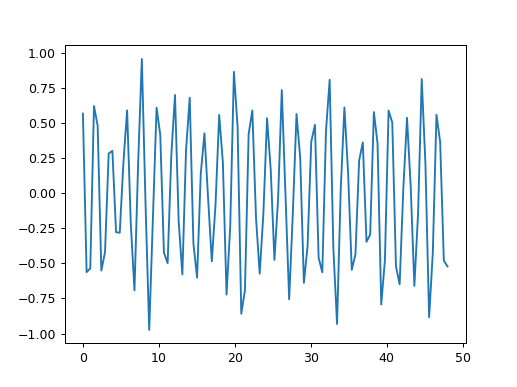

In [43]:
class Tide:
    def __init__(self, const_file="Input/tidal_constituents.csv"):
        constituents = pd.read_csv(const_file)
        self.amplitudes =  constituents["Amplitude"].to_numpy()
        self.phases = constituents["Phase"].to_numpy()
        self.speeds = constituents["Speed"].to_numpy()

    def get_tide_height(self, t):
        return np.sum(self.amplitudes * np.cos(t * self.speeds + self.phases))

tide = Tide()
h = []
ts = np.linspace(0, 48, 100)
for t in ts:
    h.append(tide.get_tide_height(1000 + t))

plt.figure()
plt.plot(ts, h)

# Draw coast height per subdivision

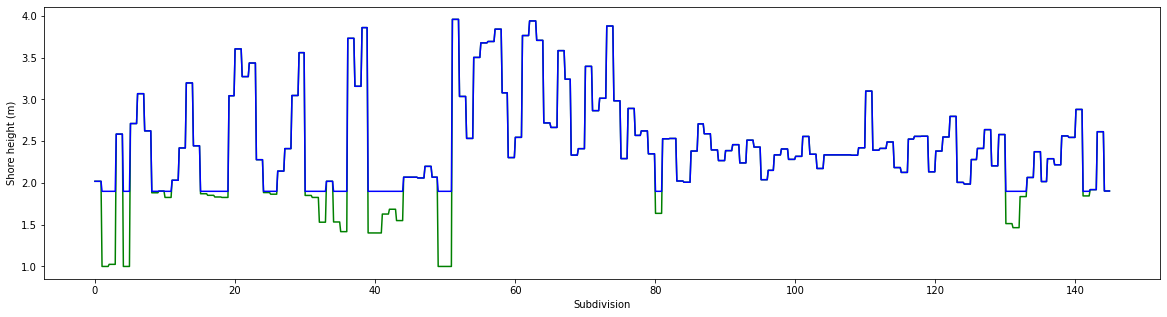

In [18]:
def coast_h(x):
    x = np.floor(x)
    return Topo.shore_height[x.astype(int)]
def coast_h_wall(x):
    x = np.floor(x)
    return Topo.shore_height_wall[x.astype(int)]

x = np.linspace(0, Topo.shore_height.size, 1000, endpoint=False)
h = coast_h(x)
h_w = coast_h_wall(x)

fig = plt.figure()
plt.plot(x, h_w, 'g')
plt.plot(x, h, 'b')

fig.set_size_inches(20,5)
plt.ylabel(r"Shore height (m)")
plt.xlabel(r"Subdivision")
plt.savefig("Output/coast_height_per_subdiv.png", transparent=True, bbox_inches='tight')

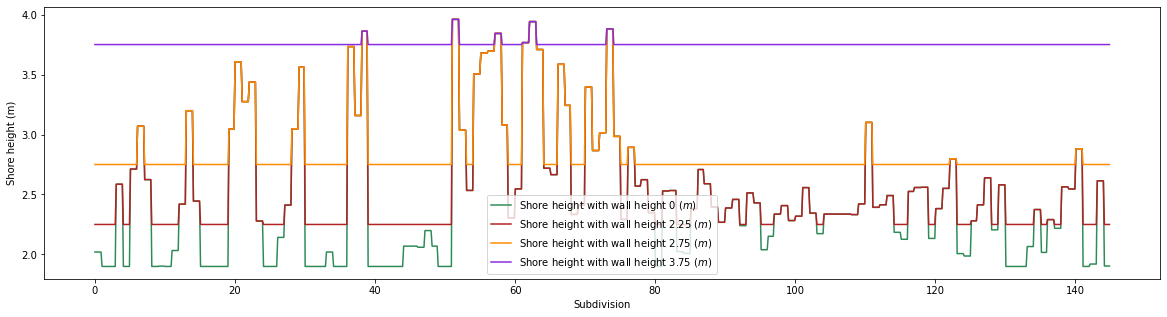

In [36]:
def coast_h_wall(x, h):
    x = np.floor(x)
    shore = Topo.shore_height[x.astype(int)]
    shore_height = [max(shore[i], h) for i in range(x.size)]
    return shore_height

x = np.linspace(0, Topo.shore_height.size, 1000, endpoint=False)

fig = plt.figure()
colors = ["seagreen", "firebrick", "darkorange", "blueviolet"]
for i, h in enumerate([0, 2.25, 2.75, 3.75]):
    height = coast_h_wall(x, h)
    lab = "Shore height with wall height " + str(h) + " $(m)$"
    plt.plot(x, height, colors[i], label=lab)

fig.set_size_inches(20,5)
plt.ylabel(r"Shore height (m)")
plt.xlabel(r"Subdivision")
plt.legend()

plt.savefig("Output/coast_height_per_subdiv_wall.png", transparent=True, bbox_inches='tight')